# Revised Magnitude tests (With larger models)
What exactly does magnitude correlate in word embeddings from Large Language Models? Can we find markers of complexity in differences between clearly defined groups of English language words?

I will compare dialects (British-English, American-English), plurals (wife, wives), and Oxford Corpus frequencies as a part of attempting to investigate these issues.

In [1]:
import os
import torch
import openai
import numpy as np

import sentencepiece    # necessary for proper t5 init.
from transformers import T5Tokenizer, T5EncoderModel, GPT2Tokenizer, OPTModel

from sklearn.metrics.pairwise import cosine_similarity

# api key set in conda env.
openai.api_key = os.getenv('OPENAI_API_KEY')

## Load Models

### Vocab

In [2]:
vocab = []
with open('./vocab/expanded_vocab.txt', 'r') as f:
    for line in f:
        vocab.append(line.strip())

len(vocab)

5124

In [3]:
top_50 = []
with open('./vocab/top_50.txt', 'r') as f:
    for line in f:
        top_50.append(line.strip())

bottom_50 = []
with open('./vocab/bottom_50.txt', 'r') as f:
    for line in f:
        bottom_50.append(line.strip())

### OPT-1.3b

In [4]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('facebook/opt-13b', cache_dir='/scratch/mbarlow6/.cache')
model_opt_raw = OPTModel.from_pretrained('facebook/opt-13b', cache_dir='/scratch/mbarlow6/.cache')

Some weights of the model checkpoint at facebook/opt-13b were not used when initializing OPTModel: ['decoder.final_layer_norm.weight', 'decoder.final_layer_norm.bias']
- This IS expected if you are initializing OPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
opt_embeds = []
with open(u'./opt/13B.txt', 'r') as f:
    for line in f:
        opt_embeds.append([float(x) for x in line.strip().split()])
model_opt = dict(zip(vocab, opt_embeds))

In [6]:
def opt_embed(text, tokenizer=gpt2_tokenizer, model=model_opt_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings[1:], dim=0))

### T5

In [7]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-3b', cache_dir='/scratch/mbarlow6/.cache')
model_t5_raw = T5EncoderModel.from_pretrained('t5-3b', cache_dir='/scratch/mbarlow6/.cache')

/home/mbarlow6/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-3b automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-3b were not used when initializing T5EncoderModel: ['decoder.block.5.layer.0.SelfAttention.o.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.10.layer.0.SelfAttention.v.w

In [8]:
t5_embeds = []
with open('./t5/t53b.txt', 'r') as f:
    for line in f:
        t5_embeds.append([float(x) for x in line.strip().split()])
model_t5 = dict(zip(vocab, t5_embeds))

In [9]:
def t5_embed(text, tokenizer=t5_tokenizer, model=model_t5_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings, dim=0))

## Helper Functions

In [10]:
def positive(words, model='opt'):
    """
    Args:
        words: iterable
        model: 'opt' or 't5'
    Returns:
        Positive (summed vectors) of word embeddings of a given list of words from the specified model. Defaults to OPT-1.3b.
    """
    if isinstance(words, str):
        print(f"You requested the positive of the string \"{words}\". Did you mean [\"{words}\"]?")

    out = 0
    for token in words:
        word = str(token)
        if model.lower() == 'opt':
            if word in model_opt:
                ex = model_opt[word]
            else:
                ex = opt_embed(word)
                model_opt[word] = ex
        elif model.lower() == 't5':
            if word in model_t5:
                ex = model_t5[word]
            else:
                ex = t5_embed(word)
                model_t5[word] = ex
        else:
            raise ValueError('Please provide either opt or t5 as a model choice.')

        # construct positive
        if isinstance(out, int):
            out = np.array(ex).reshape(1, -1)
        else:
            out += np.array(ex).reshape(1, -1)
            
    return out if not isinstance(out, int) else np.array([])

In [11]:
def sum_complexity(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the sum of the absolute value of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [abs(float(x)) for x in phrase[0]]
    return sum(modified)
    

In [12]:
def simple_sum(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the simple sum of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [float(x) for x in phrase[0]]
    return sum(modified)

In [13]:
def similar_dims(w1, w2, n=10):
    # performs dimension-wise comparison of two vectors of EQUAL size
    # returns the top and bottom n scores.
    sims = []
    for i in range(w1.shape[1]):
        x = w1[0][i]
        y = w2[0][i]
        sims.append((i, (x, y), abs(x-y)))
    sims.sort(key=lambda x: x[2])
    return sims[:n], sims[len(sims)-n:]

In [14]:
def compare_mag(words):
    """
    Wrapper for direct comparison using our magnitude tests
    """
    if isinstance(words, str):
        words = [words] 
    for word in words:
        print(word)
        print(f"\t\tOPT\t\t\tT5")
        print(f"Simple Sum:\t{simple_sum(word)}\t{simple_sum(word, model='t5')}")
        print(f"Absolute Sum:\t{sum_complexity(word)}\t{sum_complexity(word, model='t5')}")
        print('--------------------------------------------------------------\n')
        

## Run Tests

### American -> British English

In [15]:
compare_mag(['color', 'colour'])

color
		OPT			T5
Simple Sum:	284.02749621123075	3.678927972818201
Absolute Sum:	5562.393707044423	70.74662710142002
--------------------------------------------------------------

colour
		OPT			T5
Simple Sum:	308.2871670453706	-0.36761591093900153
Absolute Sum:	4768.894553013634	80.71271139074108
--------------------------------------------------------------



In [16]:
compare_mag(['flavor', 'flavour'])

flavor
		OPT			T5
Simple Sum:	160.76129966787994	2.269955031282734
Absolute Sum:	5418.792332975194	91.1318816296407
--------------------------------------------------------------

flavour
		OPT			T5
Simple Sum:	148.13053607178014	-1.349151208874997
Absolute Sum:	5330.255936812019	88.66672412593486
--------------------------------------------------------------



In [17]:
compare_mag(['apologize', 'apologise'])

apologize
		OPT			T5
Simple Sum:	84.4301058531499	3.2894353851199996
Absolute Sum:	6734.123602127542	80.29148396107993
--------------------------------------------------------------

apologise
		OPT			T5
Simple Sum:	84.13149327412248	1.635789451713208
Absolute Sum:	6244.0649045445025	55.05776584363775
--------------------------------------------------------------



In [18]:
compare_mag(['organize', 'organise'])

organize
		OPT			T5
Simple Sum:	82.49063877673963	3.969528951696
Absolute Sum:	6205.8189693342	77.02497633288802
--------------------------------------------------------------

organise
		OPT			T5
Simple Sum:	64.71635086648166	1.001984341070056
Absolute Sum:	6438.818141026422	62.0840687667951
--------------------------------------------------------------



In [19]:
compare_mag(['analyze', 'analyse'])

analyze
		OPT			T5
Simple Sum:	80.0578831769526	6.393238744116388
Absolute Sum:	5908.258793760091	81.6963346550474
--------------------------------------------------------------

analyse
		OPT			T5
Simple Sum:	104.43218374710996	3.0097302578199985
Absolute Sum:	5132.605164426451	87.64035201638005
--------------------------------------------------------------



In [20]:
compare_mag(['traveled', 'travelled'])

traveled
		OPT			T5
Simple Sum:	76.83593633025885	0.04200815415242687
Absolute Sum:	7096.610740151256	81.78613996616332
--------------------------------------------------------------

travelled
		OPT			T5
Simple Sum:	16.287957379070576	-1.848773077421356
Absolute Sum:	6780.026951023785	62.175669598102104
--------------------------------------------------------------



In [21]:
compare_mag(['maneuver', 'manoeuvre'])

maneuver
		OPT			T5
Simple Sum:	47.787557987699984	0.9321273814421147
Absolute Sum:	5410.8783700208005	82.72104415902868
--------------------------------------------------------------

manoeuvre
		OPT			T5
Simple Sum:	39.39901455875952	3.537563297402812
Absolute Sum:	5730.3853248175	86.85822214439395
--------------------------------------------------------------



In [22]:
compare_mag(['pediatric', 'paediatric'])

pediatric
		OPT			T5
Simple Sum:	73.21871189028025	3.5551710467552766
Absolute Sum:	5434.088061340153	82.9792679118691
--------------------------------------------------------------

paediatric
		OPT			T5
Simple Sum:	-7.852747055061627	3.959652184974402
Absolute Sum:	5661.01143820741	85.13007880980149
--------------------------------------------------------------



In [23]:
compare_mag(['license', 'licence'])

license
		OPT			T5
Simple Sum:	316.82228943137557	2.842006170936001
Absolute Sum:	5248.297191889368	77.88505135560396
--------------------------------------------------------------

licence
		OPT			T5
Simple Sum:	104.1187448483197	-0.5241008356399997
Absolute Sum:	4920.341891010486	78.83674501146011
--------------------------------------------------------------



In [24]:
compare_mag(['offence', 'offense'])

offence
		OPT			T5
Simple Sum:	153.48302760533971	0.8606812263100028
Absolute Sum:	5691.2485570848485	71.65387475888984
--------------------------------------------------------------

offense
		OPT			T5
Simple Sum:	146.73174711941033	3.531222570054005
Absolute Sum:	6072.457654477984	72.29150901410408
--------------------------------------------------------------



In [25]:
compare_mag(['analog', 'analogue'])

analog
		OPT			T5
Simple Sum:	106.78049531392753	4.552517701580655
Absolute Sum:	4874.807615524158	81.31557533581508
--------------------------------------------------------------

analogue
		OPT			T5
Simple Sum:	112.64309715107083	2.033608461963013
Absolute Sum:	4816.571054432541	81.29088704450987
--------------------------------------------------------------



In [26]:
compare_mag(['que', 'queue'])

que
		OPT			T5
Simple Sum:	291.5226693972945	-0.30720983166247606
Absolute Sum:	4917.625567898154	83.05059301969595
--------------------------------------------------------------

queue
		OPT			T5
Simple Sum:	340.8035239838064	0.37565266533056274
Absolute Sum:	4565.001674521714	71.5927657810389
--------------------------------------------------------------



### Simple plurals

In [27]:
compare_mag(['wife', 'wives'])

wife
		OPT			T5
Simple Sum:	352.9197482741402	3.2099152067969987
Absolute Sum:	5315.254698051018	71.48278228784298
--------------------------------------------------------------

wives
		OPT			T5
Simple Sum:	349.7733939048012	2.490675632950002
Absolute Sum:	6013.0204818953	67.94248278447002
--------------------------------------------------------------



In [28]:
compare_mag(['dog', 'dogs'])

dog
		OPT			T5
Simple Sum:	317.18741463648865	1.4517074287099982
Absolute Sum:	5219.776013053286	75.50303368280998
--------------------------------------------------------------

dogs
		OPT			T5
Simple Sum:	351.4699619412422	2.175867033714894
Absolute Sum:	5766.636604458094	80.60653716820525
--------------------------------------------------------------



In [29]:
compare_mag(['tooth', 'teeth'])

tooth
		OPT			T5
Simple Sum:	136.2660272046997	5.586464611310003
Absolute Sum:	5916.818762694925	80.53869639706991
--------------------------------------------------------------

teeth
		OPT			T5
Simple Sum:	131.59692942723632	6.04756176500814
Absolute Sum:	5835.391147468239	77.89675621310016
--------------------------------------------------------------



In [30]:
compare_mag(['man', 'men'])

man
		OPT			T5
Simple Sum:	337.9575437160964	-0.02438261295299765
Absolute Sum:	4560.874884605697	75.15917153300698
--------------------------------------------------------------

men
		OPT			T5
Simple Sum:	350.4230886362493	1.3921178152959328
Absolute Sum:	4849.990961801261	65.31367816528655
--------------------------------------------------------------



In [31]:
compare_mag(['potato', 'potatoes'])

potato
		OPT			T5
Simple Sum:	64.03492702019982	5.6283266042300095
Absolute Sum:	5585.827909953185	79.78599001515003
--------------------------------------------------------------

potatoes
		OPT			T5
Simple Sum:	74.99728013202548	1.3456275260832626
Absolute Sum:	6114.515965376049	79.54563826040248
--------------------------------------------------------------



In [32]:
compare_mag(['mouse', 'mice'])

mouse
		OPT			T5
Simple Sum:	308.25568455636926	4.008182686359796
Absolute Sum:	5297.888324492844	76.77331981899576
--------------------------------------------------------------

mice
		OPT			T5
Simple Sum:	170.4449357241392	1.9463311054860242
Absolute Sum:	5303.439270243049	79.76067198970122
--------------------------------------------------------------



In [33]:
compare_mag(['child', 'children'])

child
		OPT			T5
Simple Sum:	306.13953408801046	2.2092685180500005
Absolute Sum:	5538.062120305741	70.42164477675006
--------------------------------------------------------------

children
		OPT			T5
Simple Sum:	354.9066696125116	1.9603387856999994
Absolute Sum:	5626.700549431012	60.742690316960015
--------------------------------------------------------------



In [34]:
compare_mag(['person', 'persons', 'people'])

person
		OPT			T5
Simple Sum:	314.2149102588799	1.335161519619999
Absolute Sum:	5122.9394197871225	54.808954973199995
--------------------------------------------------------------

persons
		OPT			T5
Simple Sum:	69.06183918751776	-0.9405621207552031
Absolute Sum:	6096.755954569206	87.72749704623129
--------------------------------------------------------------

people
		OPT			T5
Simple Sum:	335.7935029352963	1.6479777115294982
Absolute Sum:	5634.969035942896	47.6999503528295
--------------------------------------------------------------



In [35]:
compare_mag(['radius', 'radii'])

radius
		OPT			T5
Simple Sum:	320.62547815591097	3.6816566849374794
Absolute Sum:	5042.196805603802	87.18898334286496
--------------------------------------------------------------

radii
		OPT			T5
Simple Sum:	110.79604643583298	0.10846690344624221
Absolute Sum:	4727.494894966483	68.46984119503759
--------------------------------------------------------------



In [36]:
compare_mag(['nucleus', 'nuclei'])

nucleus
		OPT			T5
Simple Sum:	81.97950898387353	9.317394081153907
Absolute Sum:	4498.999543369078	94.05172843311448
--------------------------------------------------------------

nuclei
		OPT			T5
Simple Sum:	62.058759771927726	8.373262314125896
Absolute Sum:	5353.554880791053	91.86660572700202
--------------------------------------------------------------



In [37]:
compare_mag(['alumna', 'alumnae', 'alumnus', 'alumni'])

alumna
		OPT			T5
Simple Sum:	35.37183149071643	-0.6007070464620483
Absolute Sum:	5482.260316117608	59.5615633796333
--------------------------------------------------------------

alumnae
		OPT			T5
Simple Sum:	2.3414500430226326	-1.0393320972007132
Absolute Sum:	6360.934125449508	63.615699048407805
--------------------------------------------------------------

alumnus
		OPT			T5
Simple Sum:	21.914447872928577	-1.09685904185244
Absolute Sum:	6206.307869313838	61.40292551125822
--------------------------------------------------------------

alumni
		OPT			T5
Simple Sum:	106.63429469615221	2.542709313100204
Absolute Sum:	5570.963578902185	81.22423035465181
--------------------------------------------------------------



In [38]:
compare_mag(['crisis', 'crises'])

crisis
		OPT			T5
Simple Sum:	134.29972921050037	3.7444229248199994
Absolute Sum:	5006.8275523064885	74.14165859276004
--------------------------------------------------------------

crises
		OPT			T5
Simple Sum:	103.65266775339842	1.4396686331820092
Absolute Sum:	6050.620089516044	54.95354784004303
--------------------------------------------------------------



In [39]:
compare_mag(['thesis', 'theses'])

thesis
		OPT			T5
Simple Sum:	159.46576607211935	5.860485378419996
Absolute Sum:	4494.805116135401	84.59150061962004
--------------------------------------------------------------

theses
		OPT			T5
Simple Sum:	132.70206608995795	1.210016303753946
Absolute Sum:	5612.207344722003	76.20478325890144
--------------------------------------------------------------



In [40]:
compare_mag(['phenomenon', 'phenomena'])

phenomenon
		OPT			T5
Simple Sum:	-0.051522275171009824	1.6362359101767652
Absolute Sum:	6632.368065319286	87.18831900012447
--------------------------------------------------------------

phenomena
		OPT			T5
Simple Sum:	0.9066889215846459	2.3911515647778288
Absolute Sum:	6320.593662376696	90.55818265595008
--------------------------------------------------------------



In [41]:
compare_mag(['datum', 'data'])

datum
		OPT			T5
Simple Sum:	125.23364223912358	1.4865362988930428
Absolute Sum:	4348.716451060027	88.56829988630489
--------------------------------------------------------------

data
		OPT			T5
Simple Sum:	335.8901131820401	1.8557073578299983
Absolute Sum:	5341.810086429096	65.53017413109004
--------------------------------------------------------------



In [42]:
compare_mag(['bacterium', 'bacteria'])

bacterium
		OPT			T5
Simple Sum:	37.70757193741156	-2.064069462940097
Absolute Sum:	5882.819221396057	67.49540099408478
--------------------------------------------------------------

bacteria
		OPT			T5
Simple Sum:	138.0673440480596	3.0154716618699995
Absolute Sum:	5972.804402588456	78.51342168415003
--------------------------------------------------------------



In [43]:
compare_mag(['index', 'indicies'])

index
		OPT			T5
Simple Sum:	349.4425496681178	5.027137501717001
Absolute Sum:	5150.850585143679	87.26000795448294
--------------------------------------------------------------

indicies
		OPT			T5
Simple Sum:	27.59071893314831	0.7541347524966113
Absolute Sum:	6035.135076975101	86.84231742221164
--------------------------------------------------------------



In [44]:
compare_mag(['appendix', 'appendices', 'appendixes'])

appendix
		OPT			T5
Simple Sum:	112.38159637525678	10.650826580356807
Absolute Sum:	5119.090969827026	86.39039552072063
--------------------------------------------------------------

appendices
		OPT			T5
Simple Sum:	105.11740968748927	5.9069801502046175
Absolute Sum:	6181.486154202372	60.70206481887726
--------------------------------------------------------------

appendixes
		OPT			T5
Simple Sum:	46.83365088677965	2.4223258049496508
Absolute Sum:	6520.856200867449	58.261959277751885
--------------------------------------------------------------



### Top 50, Bottom 50

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

In [46]:
X = bottom_50 + top_50
Y_opt = [sum_complexity(p) for p in X]
Y_t5 = [sum_complexity(p, model='t5') for p in X]
# red for bottom 50, blue for top
colors = ['r' if x < 50 else 'b' for x in range(100)]

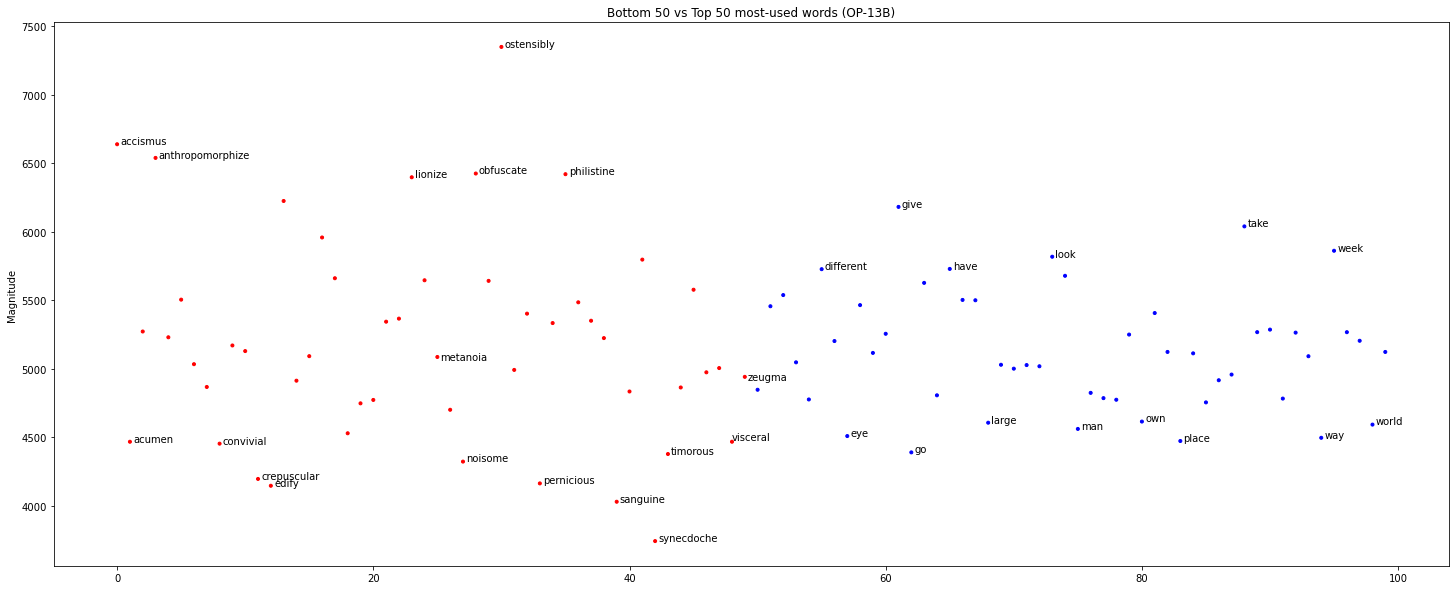

In [49]:
plt.figure(figsize=(25, 10))
plt.title('Bottom 50 vs Top 50 most-used words (OP-13B)')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_opt, c=colors, marker='.')
for i in range(0, 100):
    if i < 48:
        if i == 25:
            plt.annotate(X[i], (i+0.25, Y_opt[i]-20))
        elif Y_opt[i] > 6250:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] < 4500:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
    elif i == 48:
        plt.annotate(X[i], (i, Y_opt[i]+15))
    elif i == 49:
        plt.annotate(X[i], (i+0.25, Y_opt[i]-25))
    else:
        if Y_opt[i] < 4750:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] > 5700:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))


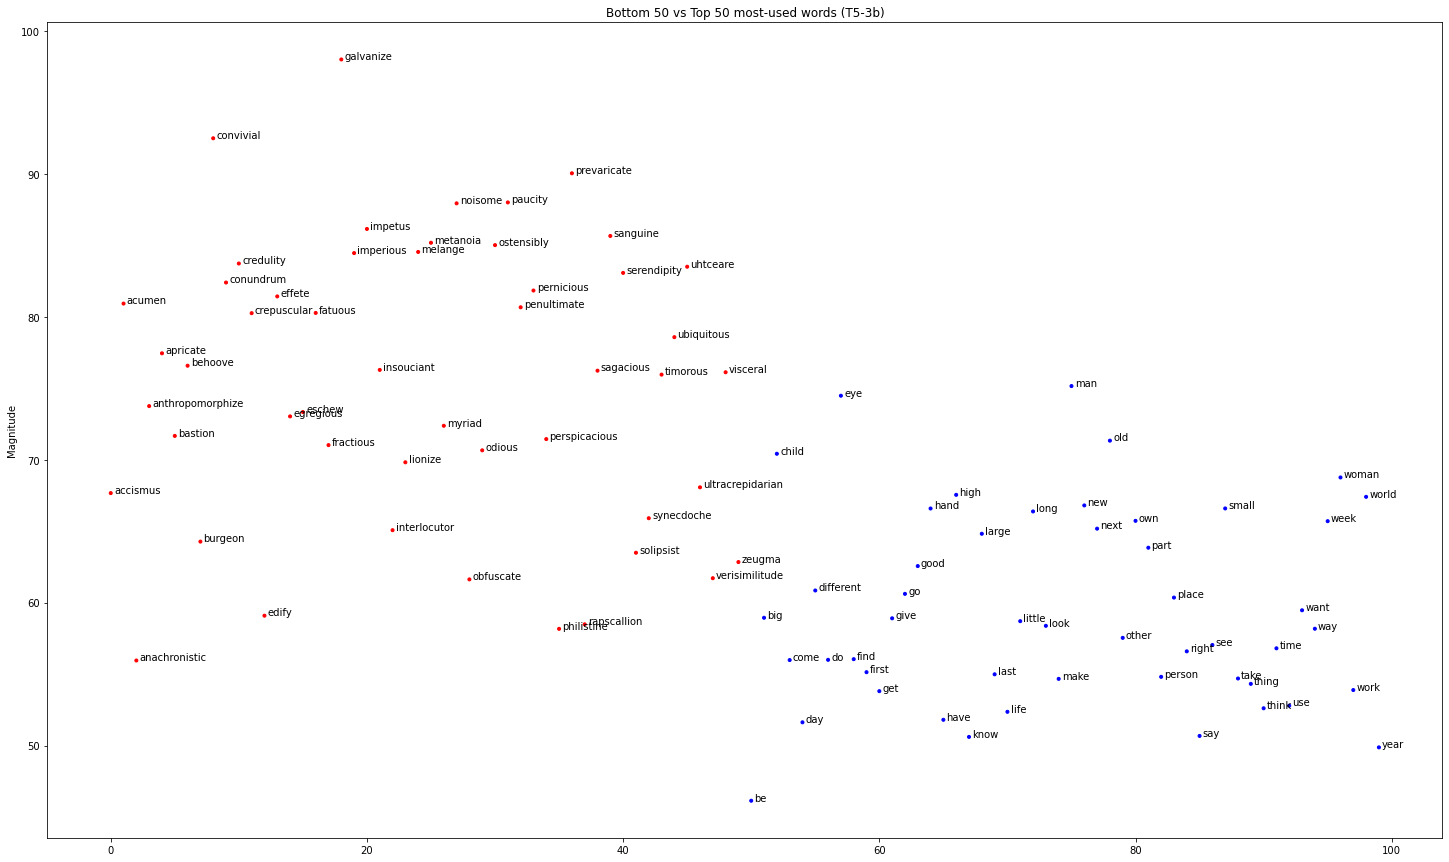

In [48]:
plt.figure(figsize=(25, 15))
plt.title('Bottom 50 vs Top 50 most-used words (T5-3b)')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_t5, c=colors, marker='.')
for i in range(0, 100):
    plt.annotate(X[i], (i+0.25, Y_t5[i]))